In [13]:
import os
import sys
from pathlib import Path

# Добавляем путь на уровень выше
sys.path.append(str(Path(os.getcwd()).resolve().parent))

from utils.features import *
from utils.load_data import load_all_data
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [14]:
data_dir = Path('../data/PEMS-BAY')
metadata, data, adj = load_all_data(data_dir)
data = data[:2016]

In [15]:
np.fill_diagonal(adj, 0)
G = nx.from_numpy_array(adj)
betweenness_centrality = nx.betweenness_centrality(G)
# Получаем значения betweenness_centrality
bc_values = list(betweenness_centrality.values())

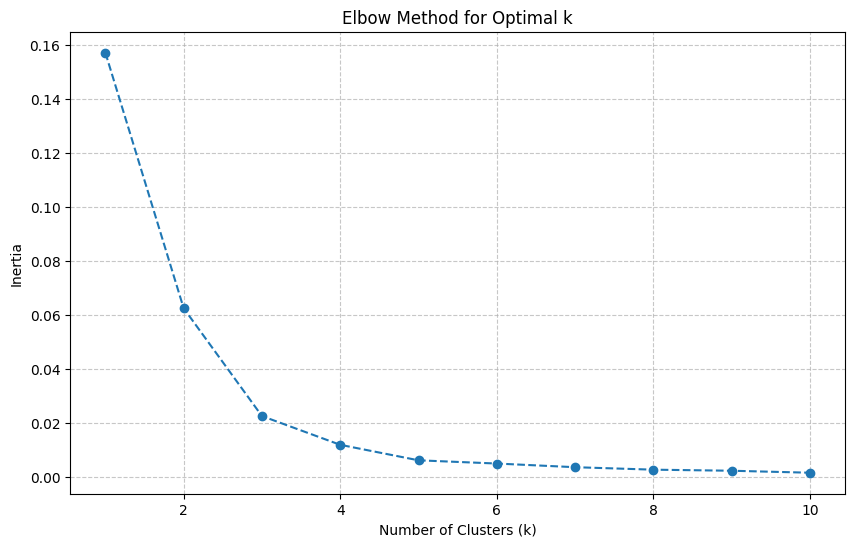

In [16]:
# Вычисляем сумму квадратов расстояний для разных значений k
inertia = []
k_values = range(1, 11)  # Проверяем от 1 до 10 кластеров
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.array(bc_values).reshape(-1, 1))
    inertia.append(kmeans.inertia_)

# Строим график "локтя"
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Применяем K-Means
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(np.array(bc_values).reshape(-1, 1))

# Получаем метки кластеров
labels = kmeans.labels_

# Создаем группы узлов на основе меток
groups = [[] for _ in range(n_clusters)]  # 5 групп, так как n_clusters=5
for node, label in zip(betweenness_centrality.keys(), labels):
    groups[label].append(node)

In [18]:
# Создаем массив для хранения средних скоростей по группам
# Форма: (time_steps, num_groups)
group_average_speeds = np.zeros((data.shape[0], n_clusters))

for i, group in enumerate(groups):
    # Выбираем данные для узлов в группе
    group_data = data[:, group, 0]  # Форма: (time_steps, num_nodes_in_group)
    
    # Усредняем по узлам (axis=1), сохраняя временной ряд
    group_average_speeds[:, i] = np.mean(group_data, axis=1)

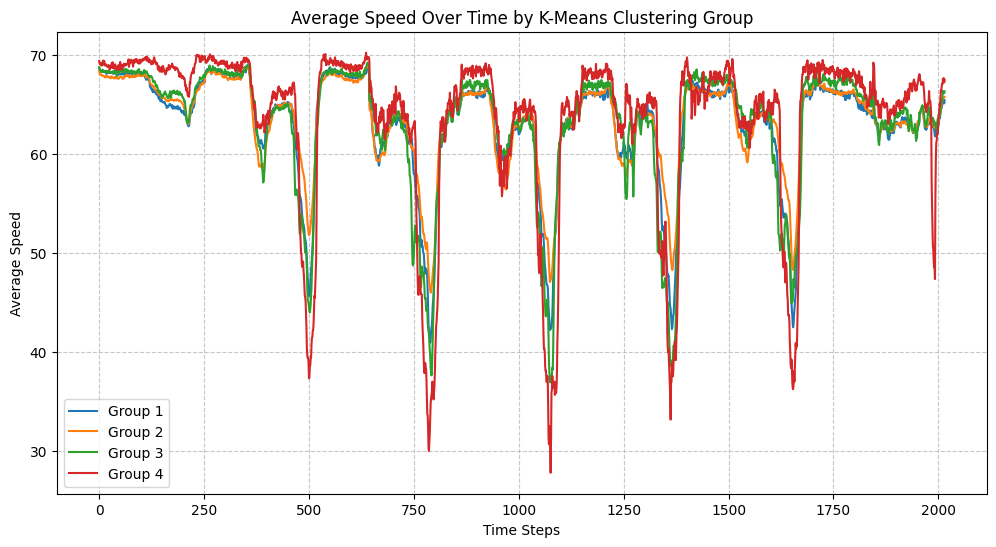

In [19]:
import matplotlib.pyplot as plt

# Временные метки (если есть)
time_steps = np.arange(data.shape[0])

# Построение графика
plt.figure(figsize=(12, 6))

for i in range(n_clusters):  # 5 групп
    plt.plot(time_steps, group_average_speeds[:, i], label=f'Group {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Speed')
plt.title('Average Speed Over Time by K-Means Clustering Group')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()

In [23]:
from sklearn.cluster import KMeans
import numpy as np
import plotly.graph_objects as go

np.fill_diagonal(adj, 0)
G = nx.from_numpy_array(adj)
betweenness_centrality = nx.betweenness_centrality(G)

# 1. Применяем K-Means
n_clusters=20
bc_values = list(betweenness_centrality.values())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(np.array(bc_values).reshape(-1, 1))
labels = kmeans.labels_

# 2. Создаем группы узлов
groups = [[] for _ in range(n_clusters)]
for node, label in zip(betweenness_centrality.keys(), labels):
    groups[label].append(node)

# 3. Вычисляем средние скорости для каждой группы
group_average_speeds = np.zeros((data.shape[0], n_clusters))
for i, group in enumerate(groups):
    group_data = data[:, group, 0]
    group_average_speeds[:, i] = np.mean(group_data, axis=1)

# 4. Построение графика с использованием Plotly
time_steps = np.arange(data.shape[0])

fig = go.Figure()
for i in range(n_clusters):
    fig.add_trace(go.Scatter(
        x=time_steps,
        y=group_average_speeds[:, i],
        mode='lines',
        name=f'Group {i+1} (Centroid: {kmeans.cluster_centers_[i][0]:.4f})'
    ))

fig.update_layout(
    title='Average Speed Over Time by K-Means Clustering Group',
    xaxis_title='Time Steps',
    yaxis_title='Average Speed',
    legend_title='Groups',
    template='plotly_white'
)

fig.show()

In [24]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx
import plotly.graph_objects as go

def cluster_graph_features(adj, data, metric='betweenness', n_clusters=5, elbow_method=False, max_clusters=20):
    """
    Кластеризация узлов графа на основе заданной метрики и вычисление средней скорости по группам.

    Параметры:
        adj (numpy.ndarray): Матрица смежности графа.
        data (numpy.ndarray): Данные [time_steps, num_nodes, features].
        metric (str): Метрика графа ('betweenness', 'degree', 'closeness', 'eigenvector').
        n_clusters (int): Количество кластеров для K-Means.
        elbow_method (bool): Если True, используется метод локтя для выбора оптимального числа кластеров.
        max_clusters (int): Максимальное количество кластеров для метода локтя.

    Возвращает:
        groups (list): Список групп узлов для каждого кластера.
        group_average_speeds (numpy.ndarray): Средние скорости для каждой группы [time_steps, n_clusters].
        fig (plotly.graph_objects.Figure): График средних скоростей по группам.
    """
    # Убираем диагональные элементы
    np.fill_diagonal(adj, 0)
    G = nx.from_numpy_array(adj)

    # Выбор метрики
    if metric == 'betweenness':
        node_values = list(nx.betweenness_centrality(G).values())
    elif metric == 'degree':
        node_values = [val for _, val in G.degree()]
    elif metric == 'closeness':
        node_values = list(nx.closeness_centrality(G).values())
    elif metric == 'eigenvector':
        node_values = list(nx.eigenvector_centrality(G, max_iter=1000).values())
    else:
        raise ValueError(f"Метрика '{metric}' не поддерживается. Выберите из: 'betweenness', 'degree', 'closeness', 'eigenvector'.")

    # Метод локтя для выбора оптимального количества кластеров
    if elbow_method:
        distortions = []
        for k in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(np.array(node_values).reshape(-1, 1))
            distortions.append(kmeans.inertia_)
        
        # Построение графика локтя
        fig_elbow = go.Figure()
        fig_elbow.add_trace(go.Scatter(x=list(range(1, max_clusters + 1)), y=distortions, mode='lines+markers'))
        fig_elbow.update_layout(
            title='Метод локтя',
            xaxis_title='Число кластеров',
            yaxis_title='Инерция (Distortion)',
            template='plotly_white'
        )
        fig_elbow.show()

        return None  # Возвращаем только график локтя, чтобы пользователь выбрал n_clusters

    # Применение K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(np.array(node_values).reshape(-1, 1))
    labels = kmeans.labels_

    # Создание групп узлов
    groups = [[] for _ in range(n_clusters)]
    for node, label in zip(range(len(node_values)), labels):
        groups[label].append(node)

    # Вычисление средних скоростей для каждой группы
    group_average_speeds = np.zeros((data.shape[0], n_clusters))
    for i, group in enumerate(groups):
        group_data = data[:, group, 0]  # Используем первый канал для вычислений
        group_average_speeds[:, i] = np.mean(group_data, axis=1)

    # Построение графика
    time_steps = np.arange(data.shape[0])
    fig = go.Figure()
    for i in range(n_clusters):
        fig.add_trace(go.Scatter(
            x=time_steps,
            y=group_average_speeds[:, i],
            mode='lines',
            name=f'Group {i+1} (Centroid: {kmeans.cluster_centers_[i][0]:.4f})'
        ))

    fig.update_layout(
        title=f'Средняя скорость по группам (Метрика: {metric})',
        xaxis_title='Временные шаги',
        yaxis_title='Средняя скорость',
        legend_title='Группы',
        template='plotly_white'
    )

    return groups, group_average_speeds, fig


In [27]:
cluster_graph_features(adj, data, metric='degree', elbow_method=True, max_clusters=15)

groups, group_average_speeds, fig = cluster_graph_features(adj, data, metric='degree', n_clusters=5)
fig.show()